# Bollinger band mean reversion

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

In [2]:
df = pd.read_csv("../data/progress.csv")
df = df.set_index(pd.to_datetime(df.time)).drop(["time"], axis=1)

In [3]:
def bbands(price, window=None, width=None, numsd=None):
    """ returns average, upper band, and lower band"""
    ave = price.rolling(window).mean()
    sd = price.rolling(window).std(ddof=0)
    if width:
        upband = ave * (1+width)
        dnband = ave * (1-width)
        return price, np.round(ave,3), np.round(upband,3), np.round(dnband,3)        
    if numsd:
        upband = ave + (sd*numsd)
        dnband = ave - (sd*numsd)
        return price, np.round(ave,3), np.round(upband,3), np.round(dnband,3)

In [4]:
window=500
df0 = pd.DataFrame()
df0['price'],df0['ave'],df0['upper'],df0['lower']=bbands(df.close, window=window, numsd=1)
df0.dropna(inplace=True)
df0

,price,ave,upper,lower
time,,,,
2021-01-08 20:36:39.962,40375.13,40086.154,40241.107,39931.202
2021-01-08 20:36:44.357,40395.04,40086.754,40242.319,39931.188
2021-01-08 20:36:46.652,40383.96,40087.284,40243.408,39931.159
2021-01-08 20:36:46.662,40371.00,40087.767,40244.394,39931.139
2021-01-08 20:36:49.200,40403.38,40088.315,40245.565,39931.065
...,...,...,...,...
2021-01-10 23:26:03.620,33291.65,33288.493,33455.089,33121.896
2021-01-10 23:26:05.362,33287.33,33289.622,33454.282,33124.961
2021-01-10 23:26:06.023,33238.66,33290.734,33453.153,33128.315


In [9]:
def get_up_cross(df, col):
    # col is price column
    crit1 = df[col].shift(1) < df.upper.shift(1)  
    crit2 = df[col] > df.upper
    return df[col][(crit1) & (crit2)]

def get_down_cross(df, col):
    # col is price column    
    crit1 = df[col].shift(1) > df.lower.shift(1) 
    crit2 = df[col] < df.lower
    return df[col][(crit1) & (crit2)]

bb_down = get_down_cross(df0, 'price')
bb_up = get_up_cross(df0, 'price') 

In [7]:
bb_side_up = pd.Series(-1, index=bb_up.index) # sell on up cross for mean reversion
bb_side_down = pd.Series(1, index=bb_down.index) # buy on down cross for mean reversion
side = pd.concat([bb_side_up,bb_side_down]).sort_index()
side

time
2021-01-08 20:45:26.381   -1
2021-01-08 20:48:21.749   -1
2021-01-08 20:49:17.612   -1
2021-01-08 20:49:27.796   -1
2021-01-08 21:00:24.806    1
                          ..
2021-01-10 23:22:58.773   -1
2021-01-10 23:23:02.390   -1
2021-01-10 23:23:04.410   -1
2021-01-10 23:24:24.929   -1
2021-01-10 23:25:16.028   -1
Length: 1699, dtype: int64

In [ ]:
df0.to_csv("../data/progress2.csv")
side.to_csv("../data/side.csv")

## Plotting

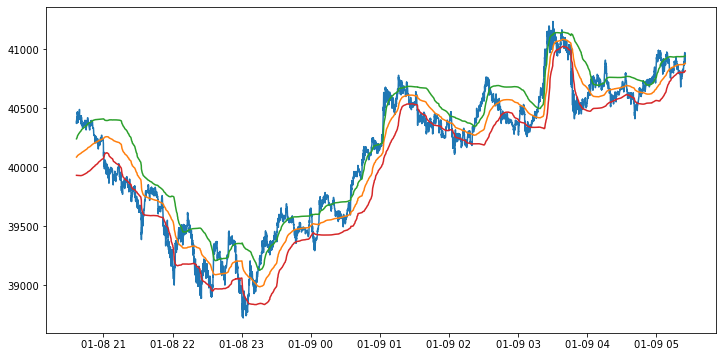

In [8]:
f,ax=plt.subplots(figsize=(12,6))
# df0.plot(ax=ax)
ax.plot(df0[:10000])

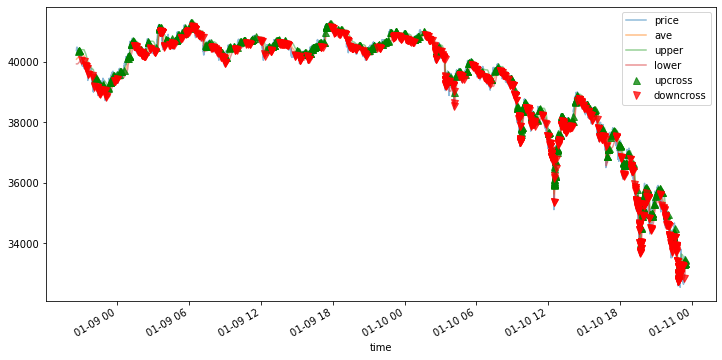

In [10]:
f, ax = plt.subplots(figsize=(12,6))

df0.loc['2014':].plot(ax=ax, alpha=.5)
bb_up.loc['2014':].plot(ax=ax, ls='', marker='^', markersize=7,
                        alpha=0.75, label='upcross', color='g')
bb_down.loc['2014':].plot(ax=ax, ls='', marker='v', markersize=7, 
                          alpha=0.75, label='downcross', color='r')
ax.legend()